In [6]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

import pickle

UNDERSTANDING THE DATA

In [12]:
df = pd.read_csv(r"C:\Users\3520(i5)\Documents\Datascientist\Shopper Spectrum\online_retail.csv",encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df.shape

(541909, 8)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [15]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [16]:
df.duplicated().sum()

np.int64(5268)

In [17]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data Preprocessing

In [18]:
# 1. Drop rows with missing CustomerID
df_cleaned = df.dropna(subset=["CustomerID"])

# 2. Remove cancelled invoices (it starts with 'C')
df_cleaned = df_cleaned[~df_cleaned["InvoiceNo"].astype(str).str.startswith("C")]

# 3. Remove rows with negative Quantity or UnitPrice
df_cleaned = df_cleaned[(df_cleaned["Quantity"] > 0) & (df_cleaned["UnitPrice"] > 0)]

# 4. Convert InvoiceDate to datetime
df_cleaned["InvoiceDate"] = pd.to_datetime(df_cleaned["InvoiceDate"])

# Optional: Reset index
df_cleaned.reset_index(drop=True, inplace=True)

# View the cleaned data
print(df_cleaned.info())
print(df_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    

In [19]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


Exploratory Data Analysis (EDA)

In [20]:
# 1. Transaction volume by country (excluding UK for contrast)
country_counts = df_cleaned[df_cleaned["Country"] != "United Kingdom"]["Country"].value_counts().head(10)

# 2. Top 10 selling products
top_products = df_cleaned["Description"].value_counts().head(10)

# 3. Purchase trends over time (daily)
daily_sales = df_cleaned.set_index("InvoiceDate").resample("D").size()

# 4. Total amount for each row
df_cleaned["TotalAmount"] = df_cleaned["Quantity"] * df_cleaned["UnitPrice"]

# 5. Distribution per transaction
transaction_amounts = df_cleaned.groupby("InvoiceNo")["TotalAmount"].sum()

# 6. Distribution per customer
customer_amounts = df_cleaned.groupby("CustomerID")["TotalAmount"].sum()

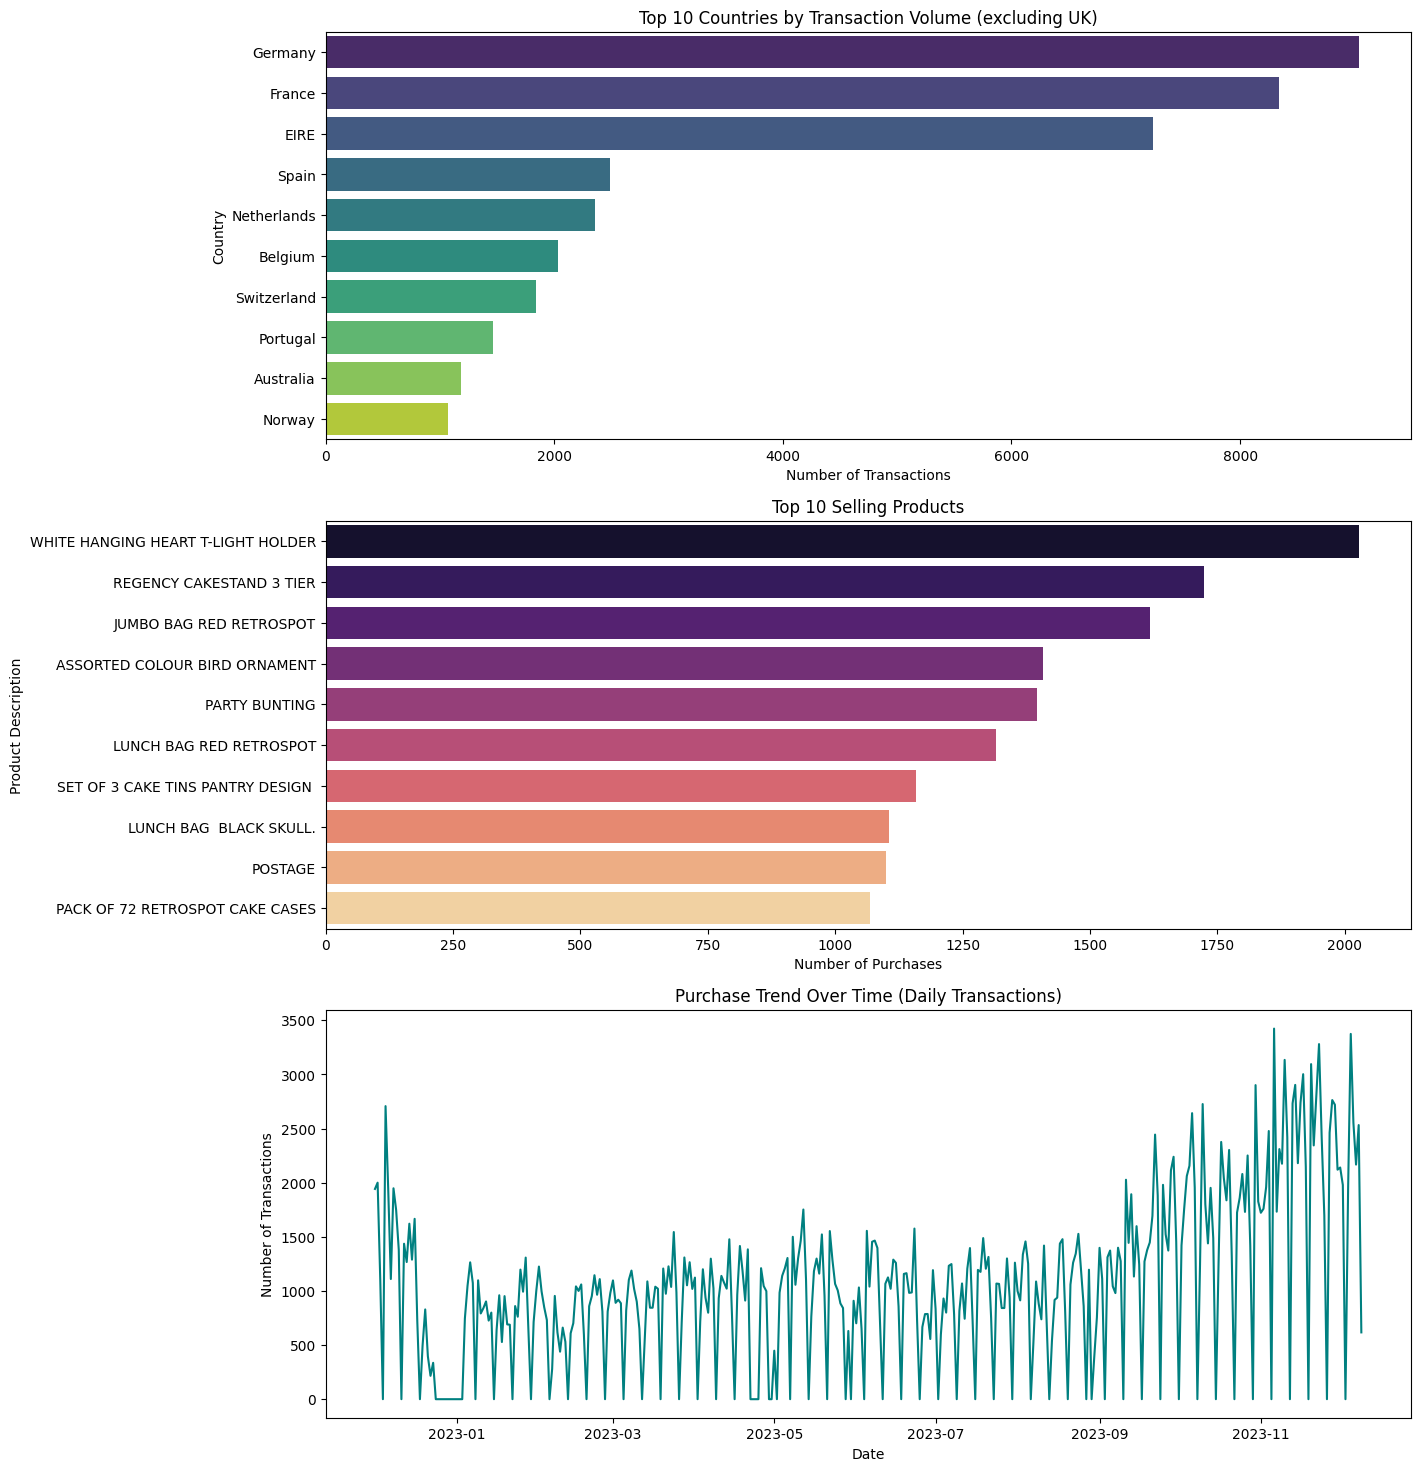

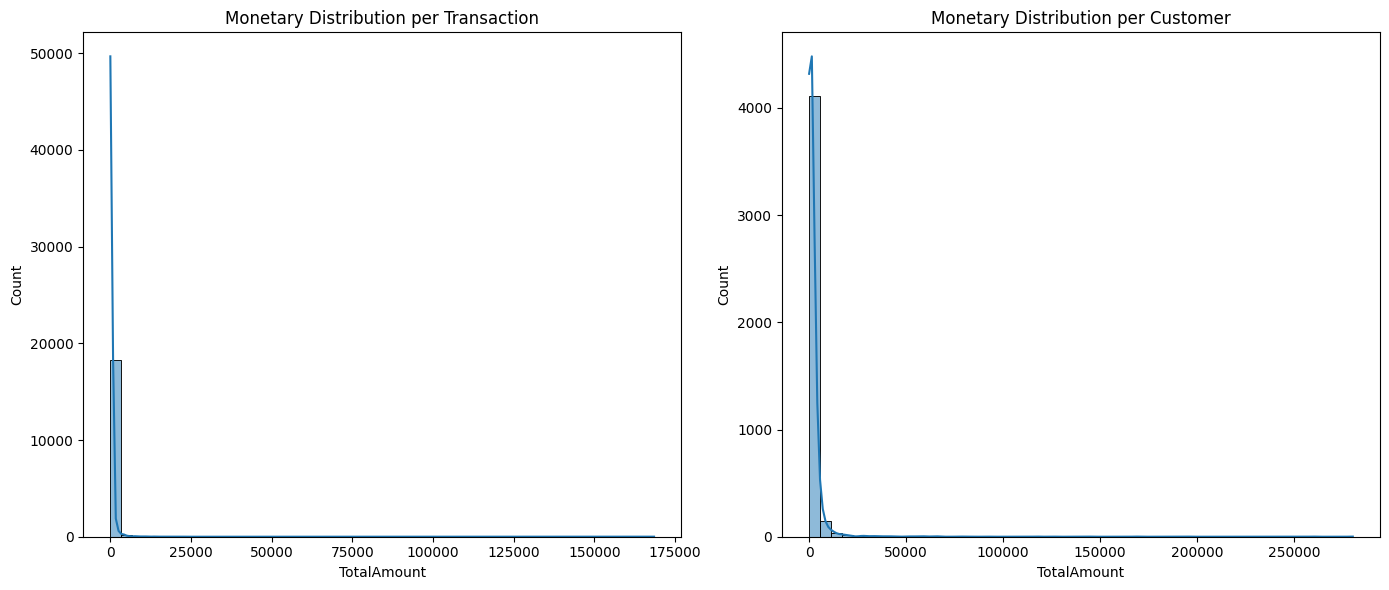

In [21]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

# Plot 1: Top 10 Countries by Transaction Volume
sns.barplot(x=country_counts.values, y=country_counts.index, ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 Countries by Transaction Volume (excluding UK)")
axes[0].set_xlabel("Number of Transactions")
axes[0].set_ylabel("Country")

# Plot 2: Top 10 Selling Products
sns.barplot(x=top_products.values, y=top_products.index, ax=axes[1], palette="magma")
axes[1].set_title("Top 10 Selling Products")
axes[1].set_xlabel("Number of Purchases")
axes[1].set_ylabel("Product Description")

# Plot 3: Daily Purchase Trend
axes[2].plot(daily_sales.index, daily_sales.values, color="teal")
axes[2].set_title("Purchase Trend Over Time (Daily Transactions)")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Number of Transactions")

# Plot 4: Monetary Distribution per Transaction
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(transaction_amounts, bins=50, kde=True)
plt.title("Monetary Distribution per Transaction")

# Plot 5: Monetary Distribution per Customer
plt.subplot(1,2,2)
sns.histplot(customer_amounts, bins=50, kde=True)
plt.title("Monetary Distribution per Customer")


plt.tight_layout()
plt.show()


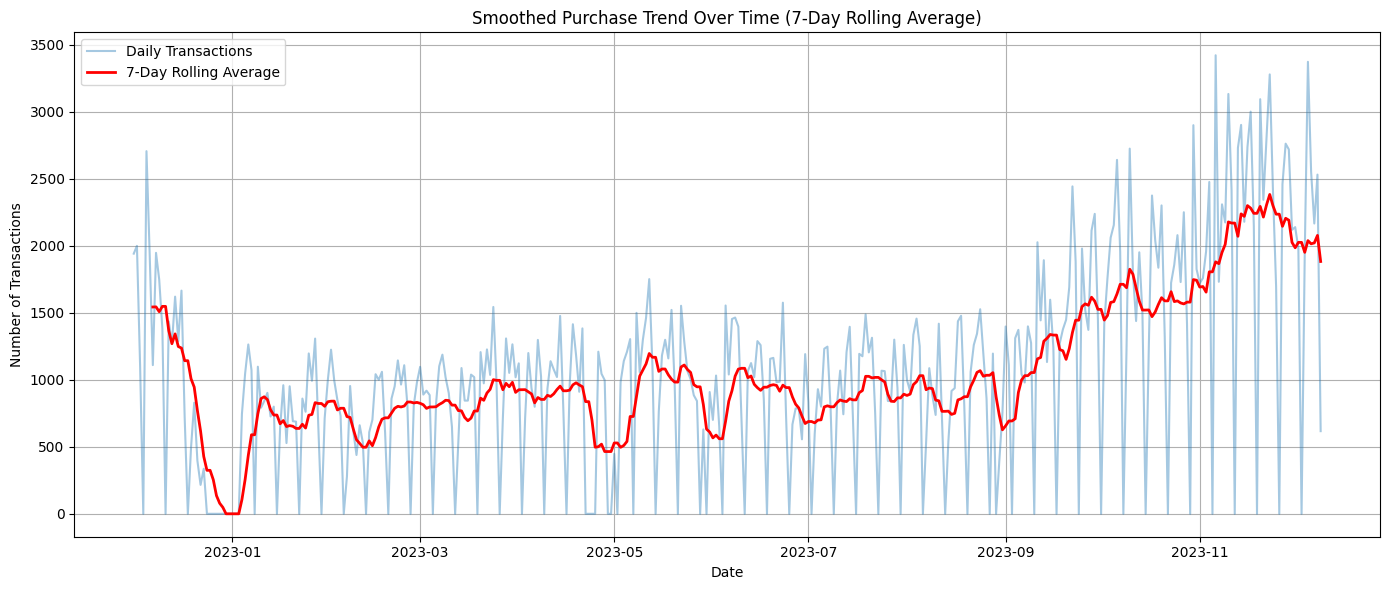

In [22]:
# Set the invoice date as index
df_cleaned["InvoiceDate"] = pd.to_datetime(df_cleaned["InvoiceDate"])
daily_sales = df_cleaned.set_index("InvoiceDate").resample("D").size()

# Apply 7-day rolling average
rolling_avg = daily_sales.rolling(window=7).mean()

# Plot original vs smoothed
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales, label='Daily Transactions', alpha=0.4)
plt.plot(rolling_avg.index, rolling_avg, label='7-Day Rolling Average', color='red', linewidth=2)
plt.title("Smoothed Purchase Trend Over Time (7-Day Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
df_cleaned.to_csv(r"C:\Users\3520(i5)\Documents\Datascientist\Shopper Spectrum\SHOPPERDATACLEANED.csv", index=False)

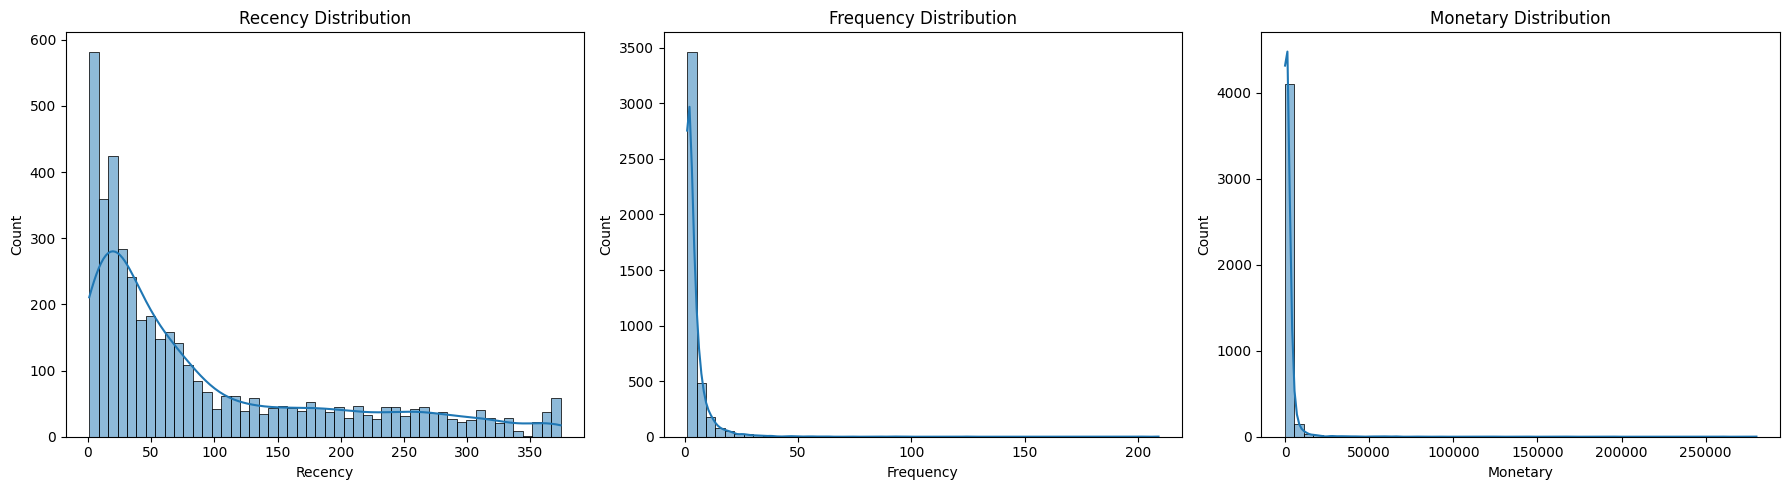

In [26]:
# Define snapshot date as one day after the last invoice
snapshot_date = df_cleaned["InvoiceDate"].max() + dt.timedelta(days=1)

# Group by CustomerID
rfm = df_cleaned.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
})
rfm.columns = ["Recency", "Frequency", "Monetary"]

# Plot RFM Distributions
plt.figure(figsize=(18,5))
for i, column in enumerate(rfm.columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm[column], bins=50, kde=True)
    plt.title(f"{column} Distribution")
plt.tight_layout()
plt.show()

In [27]:
# Cap extreme values using the 99th percentile
rfm["Monetary"] = np.where(
    rfm["Monetary"] > rfm["Monetary"].quantile(0.99),
    rfm["Monetary"].quantile(0.99),
    rfm["Monetary"]
)

In [28]:
rfm["Monetary_log"] = np.log1p(rfm["Monetary"])
rfm["Recency_log"] = np.log1p(rfm["Recency"])
rfm["Frequency_log"] = np.log1p(rfm["Frequency"])

In [29]:
rfm_log = rfm[["Recency_log", "Frequency_log", "Monetary_log"]]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

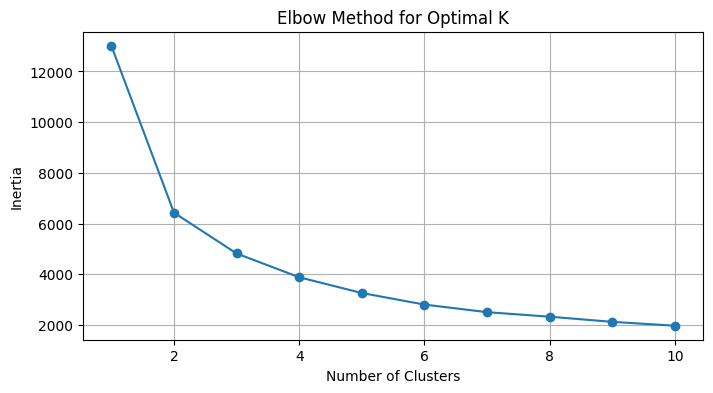

In [30]:
# Elbow Curve for Optimal Clusters (KMeans)

# Elbow Method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

Model selection

In [31]:
#KMEANS CLUSTER

kmeans = KMeans(n_clusters=4, random_state=42)
rfm["KMeans_Cluster"] = kmeans.fit_predict(rfm_scaled)
kmeans_score = silhouette_score(rfm_scaled, rfm["KMeans_Cluster"])
print(f"KMeans Silhouette Score: {kmeans_score:.3f}")

KMeans Silhouette Score: 0.337


In [32]:
#DBSCAN_CLUSTER

dbscan = DBSCAN(eps=1.2, min_samples=5)

# Run DBSCAN and store results
rfm["DBSCAN_Cluster"] = dbscan.fit_predict(rfm_scaled)

# Count valid (non-noise) clusters
valid_clusters = rfm["DBSCAN_Cluster"].nunique() - (1 if -1 in rfm["DBSCAN_Cluster"].unique() else 0)

# Compute Silhouette Score only if valid
if valid_clusters >= 2:
    score = silhouette_score(
        rfm_scaled[rfm["DBSCAN_Cluster"] != -1],
        rfm.loc[rfm["DBSCAN_Cluster"] != -1, "DBSCAN_Cluster"]
    )
    print(f"DBSCAN Silhouette Score: {score:.3f}")
else:
    print("⚠️ Not enough valid clusters to compute silhouette score.")

⚠️ Not enough valid clusters to compute silhouette score.


In [33]:
#HIERARCHIAL CLUSTER

hier = AgglomerativeClustering(n_clusters=4)
rfm["Hierarchical_Cluster"] = hier.fit_predict(rfm_scaled)
hier_score = silhouette_score(rfm_scaled, rfm["Hierarchical_Cluster"])
print(f"Hierarchical Silhouette Score: {hier_score:.3f}")

Hierarchical Silhouette Score: 0.277


In [34]:
print(f"""
🔍 Model Comparison (Silhouette Scores):

- KMeans:        {kmeans_score:.3f}
- Hierarchical:  {hier_score:.3f}
""")


🔍 Model Comparison (Silhouette Scores):

- KMeans:        0.337
- Hierarchical:  0.277



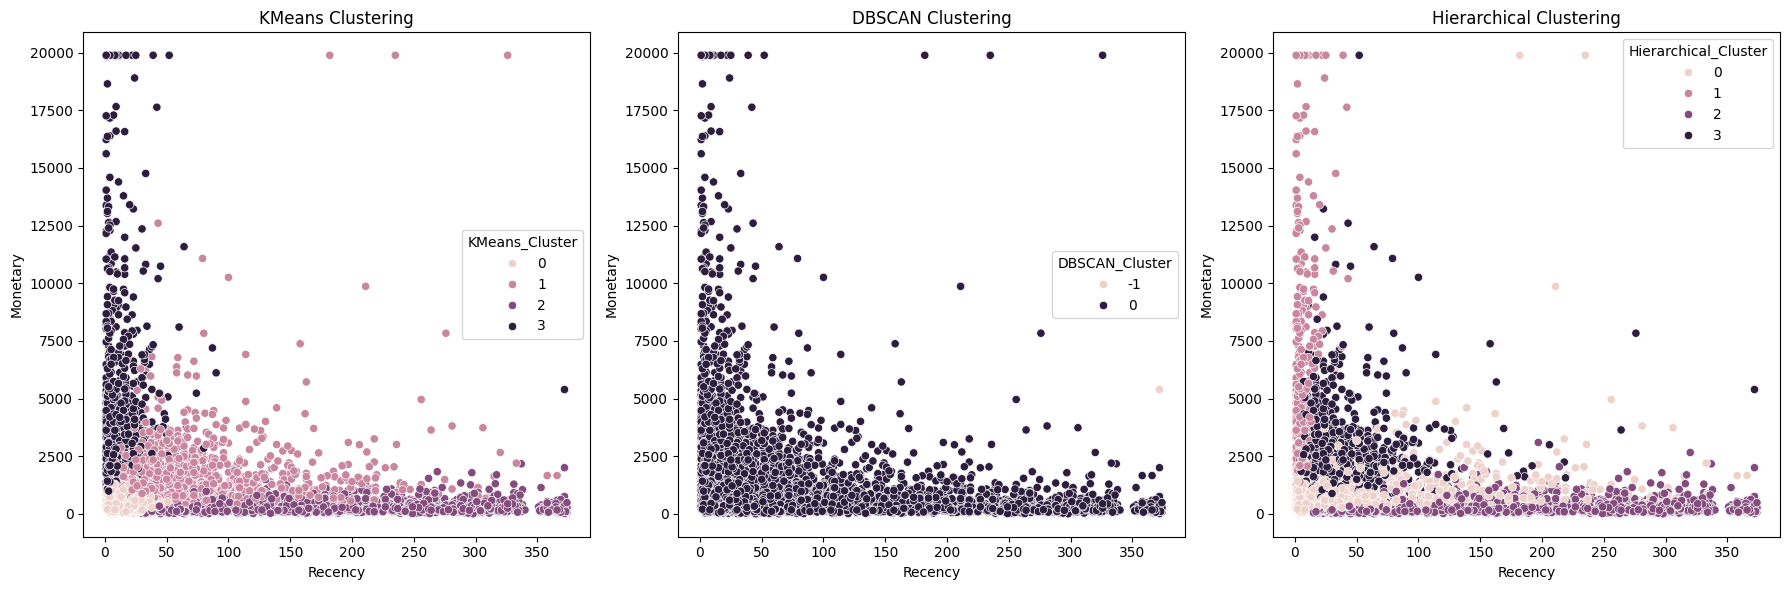

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# KMeans
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["KMeans_Cluster"], ax=axes[0])
axes[0].set_title("KMeans Clustering")

# DBSCAN
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["DBSCAN_Cluster"], ax=axes[1])
axes[1].set_title("DBSCAN Clustering")

# Hierarchical
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], hue=rfm["Hierarchical_Cluster"], ax=axes[2])
axes[2].set_title("Hierarchical Clustering")

plt.tight_layout()
plt.show()

MODEL K MEANS

In [36]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(rfm_pca)

sil_score = silhouette_score(rfm_pca, labels)
print(f"Silhouette Score with PCA: {sil_score:.3f}")

Silhouette Score with PCA: 0.379


         Recency  Frequency  Monetary  Monetary_log  Recency_log  \
Cluster                                                            
0          21.11       1.94    475.29          5.95         2.84   
1          11.76      13.35   5328.43          8.27         2.13   
2         189.14       1.32    361.81          5.63         5.09   
3          67.72       4.14   1695.47          7.24         3.96   

         Frequency_log  KMeans_Cluster  DBSCAN_Cluster  Hierarchical_Cluster  
Cluster                                                                       
0                 1.03            0.12             0.0                  0.40  
1                 2.45            2.92            -0.0                  1.74  
2                 0.82            1.98             0.0                  1.82  
3                 1.58            0.99             0.0                  1.25  


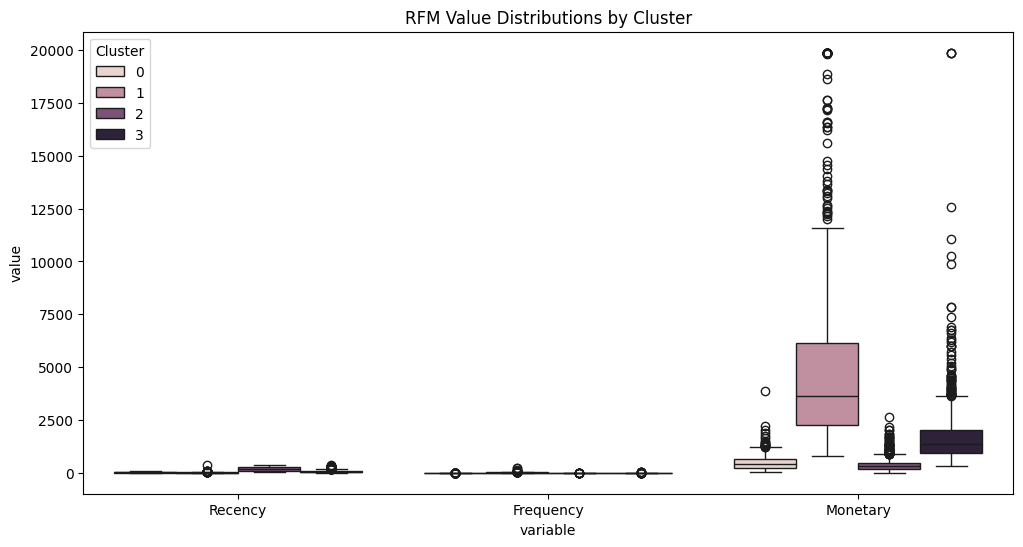

In [37]:
#Customer Cluster Profiles

#k=4 from elbow method
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_pca)

# Labeling clusters
cluster_profiles = rfm.groupby("Cluster").mean().round(2)
print(cluster_profiles)

# Visualize RFM by cluster
rfm_melted = rfm.reset_index().melt(id_vars=["CustomerID", "Cluster"], value_vars=["Recency", "Frequency", "Monetary"])
plt.figure(figsize=(12,6))
sns.boxplot(data=rfm_melted, x="variable", y="value", hue="Cluster")
plt.title("RFM Value Distributions by Cluster")
plt.show()

In [38]:
# Step 1: Profile each cluster
cluster_profiles = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"
}).round(2)

# Step 2: Sort clusters for interpretation
# Lower recency = better (more recent), so we invert it for ranking
cluster_profiles["RecencyRank"] = cluster_profiles["Recency"].rank(method="min", ascending=True)
cluster_profiles["FrequencyRank"] = cluster_profiles["Frequency"].rank(method="min", ascending=False)
cluster_profiles["MonetaryRank"] = cluster_profiles["Monetary"].rank(method="min", ascending=False)

# Sum ranks to get overall score
cluster_profiles["Score"] = cluster_profiles[["RecencyRank", "FrequencyRank", "MonetaryRank"]].sum(axis=1)

# Step 3: Assign labels based on score
# You can change this mapping logic based on actual profiles
segment_map = {
    cluster_profiles["Score"].idxmin(): "High-Value",
    cluster_profiles["Score"].idxmax(): "At-Risk",
}

# Assign remaining clusters
remaining = [i for i in cluster_profiles.index if i not in segment_map]
remaining_scores = cluster_profiles.loc[remaining].sort_values("Score")

segment_map[remaining_scores.index[0]] = "Regular"
segment_map[remaining_scores.index[1]] = "Occasional"

# Step 4: Map back to RFM table
rfm["Segment"] = rfm["Cluster"].map(segment_map)

In [39]:
rfm["Segment"].value_counts()

Segment
At-Risk       1556
Regular       1187
Occasional     853
High-Value     742
Name: count, dtype: int64

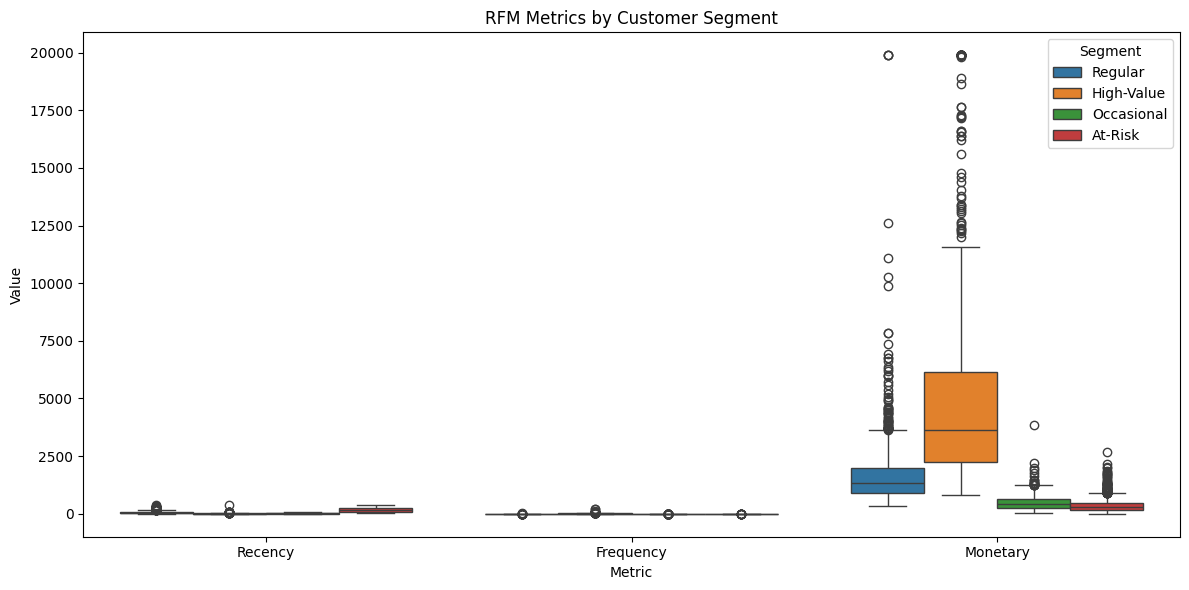

In [40]:
# Melt the RFM dataframe for visualization
rfm_melted = rfm.reset_index().melt(id_vars=["CustomerID", "Segment"], 
                                    value_vars=["Recency", "Frequency", "Monetary"],
                                    var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=rfm_melted, x="Metric", y="Value", hue="Segment")
plt.title("RFM Metrics by Customer Segment")
plt.tight_layout()
plt.show()

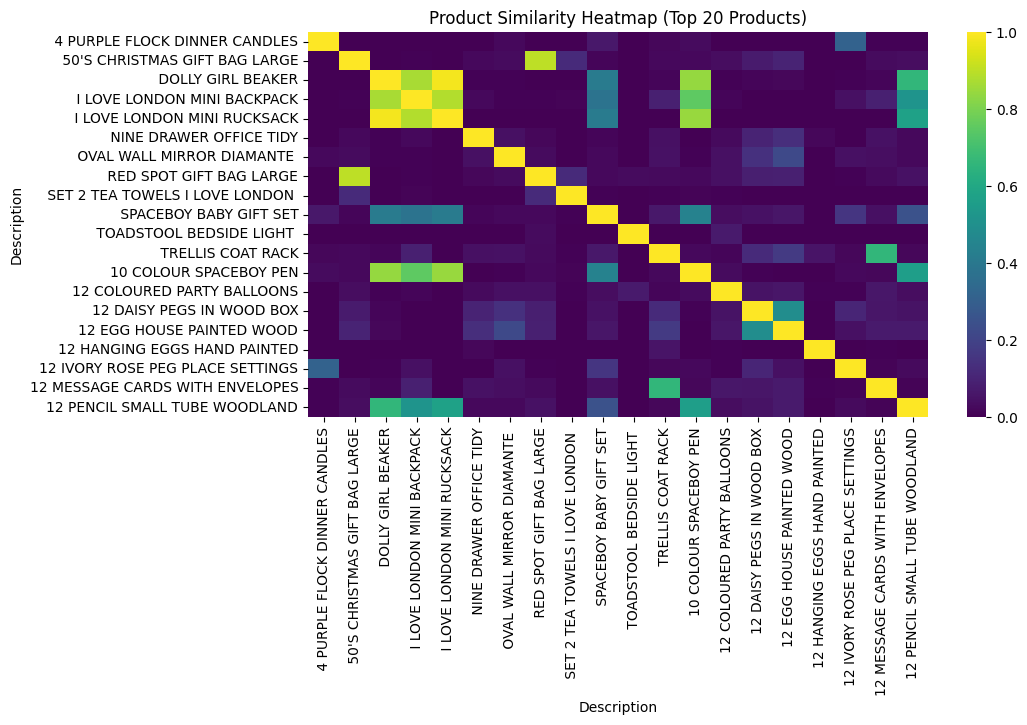

In [41]:
#Product Recommendation – Similarity Matrix

# Create Customer-Product matrix
pivot = df_cleaned.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum', fill_value=0)

# Compute cosine similarity between products
product_similarity = cosine_similarity(pivot.T)
product_similarity_df = pd.DataFrame(product_similarity, index=pivot.columns, columns=pivot.columns)

with open("product_similarity_matrix.pkl", "wb") as f:
    pickle.dump(product_similarity_df, f)

# Plot heatmap
plt.figure(figsize=(10,5))
sns.heatmap(product_similarity_df.iloc[:20, :20], cmap="viridis")
plt.title("Product Similarity Heatmap (Top 20 Products)")
plt.show()

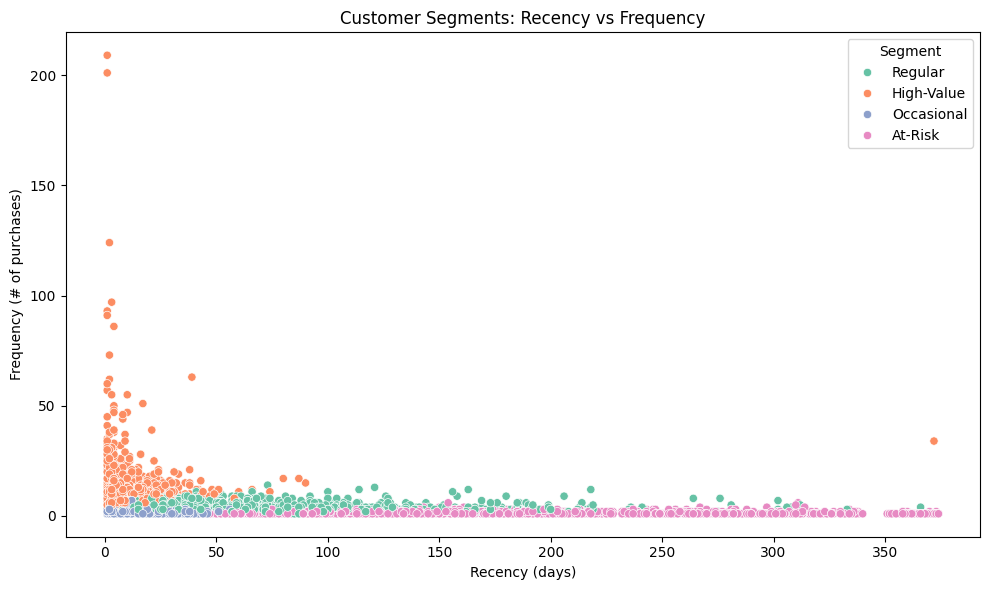

In [42]:
# Simple 2D plot of Recency vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Frequency",
    hue="Segment",
    palette="Set2"
)
plt.title("Customer Segments: Recency vs Frequency")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency (# of purchases)")
plt.legend(title="Segment")
plt.tight_layout()
plt.show()

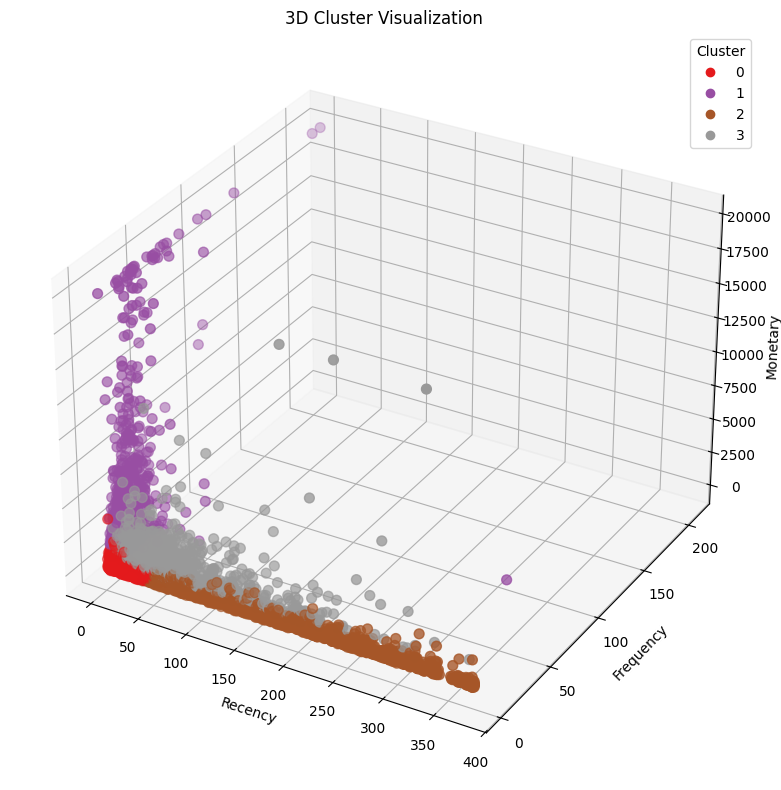

In [43]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm["Recency"],
    rfm["Frequency"],
    rfm["Monetary"],
    c=rfm["Cluster"],
    cmap="Set1",
    s=50
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Cluster Visualization")

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [44]:
def get_similar_products(product_name, similarity_matrix, top_n=5):
    if product_name not in similarity_matrix.columns:
        return f"'{product_name}' not found in product list."
    
    # Sort by similarity
    similar_scores = similarity_matrix[product_name].sort_values(ascending=False)
    top_similar = similar_scores.iloc[1:top_n+1]  # skip the product itself (similarity=1)
    
    return top_similar

In [45]:
# Step 1: Ask user for product name
product_name = input("Enter a product name: ")

# Step 2: Check if product is in the similarity matrix
if product_name in product_similarity_df.columns:
    # Step 3: Get top similar products
    recommendations = get_similar_products(product_name, product_similarity_df)

    # Step 4: Print recommendations
    print("\nTop similar products:")
    for prod, score in recommendations.items():
        print(f"🔹 {prod} (Similarity: {score:.2f})")
else:
    print(f"⚠️ '{product_name}' not found in the product list.")

⚠️ 't shot' not found in the product list.


In [46]:
# Dictionary to hold model components
model_data = {
    "model": kmeans,          # your KMeans model
    "scaler": scaler,         # StandardScaler used before clustering
    "segment_map": segment_map  # optional: mapping cluster ID -> segment name
}

# Save to file
with open("rfm_kmeans_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

In [47]:
df.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2022-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2022-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2022-12-01 08:34:00,1.69,13047.0,United Kingdom
